# K-means Clustering 

In this exercise, you will implement the K-means algorithm and use it for image compression. 

* You will start with a sample dataset that will help you gain an intuition of how the K-means algorithm works. 
* After that, you will use the K-means algorithm for image compression by reducing the number of colors that occur in an image to only those that are most common in that image.




# Outline
- [ 1 - Implementing K-means](#1)
  - [ 1.1 Finding closest centroids](#1.1)
    - [ Exercise 1](#ex01)
  - [ 1.2 Computing centroid means](#1.2)
    - [ Exercise 2](#ex02)
- [ 2 - K-means on a sample dataset ](#2)
- [ 3 - Random initialization](#3)
- [ 4 - Image compression with K-means](#4)
  - [ 4.1 Dataset](#4.1)
  - [ 4.2 K-Means on image pixels](#4.2)
  - [ 4.3 Compress the image](#4.3)


In [123]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *

%matplotlib inline

<a name="1"></a>
## 1 - Implementing K-means

The K-means algorithm is a method to automatically cluster similar
data points together. 

* Concretely, you are given a training set $\{x^{(1)}, ..., x^{(m)}\}$, and you want
to group the data into a few cohesive “clusters”. 


* K-means is an iterative procedure that
     * Starts by guessing the initial centroids, and then 
     * Refines this guess by 
         * Repeatedly assigning examples to their closest centroids, and then 
         * Recomputing the centroids based on the assignments.
         

* In pseudocode, the K-means algorithm is as follows:

    ``` python
    # Initialize centroids
    # K is the number of clusters
    centroids = kMeans_init_centroids(X, K)
    
    for iter in range(iterations):
        # Cluster assignment step: 
        # Assign each data point to the closest centroid. 
        # idx[i] corresponds to the index of the centroid 
        # assigned to example i
        idx = find_closest_centroids(X, centroids)

        # Move centroid step: 
        # Compute means based on centroid assignments
        centroids = compute_centroids(X, idx, K)
    ```


* The inner-loop of the algorithm repeatedly carries out two steps: 
    1. Assigning each training example $x^{(i)}$ to its closest centroid, and
    2. Recomputing the mean of each centroid using the points assigned to it. 
    
    
* The $K$-means algorithm will always converge to some final set of means for the centroids. 

* However, the converged solution may not always be ideal and depends on the initial setting of the centroids.
    * Therefore, in practice the K-means algorithm is usually run a few times with different random initializations. 
    * One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion).

You will implement the two phases of the K-means algorithm separately
in the next sections. 
* You will start by completing `find_closest_centroid` and then proceed to complete `compute_centroids`.

<a name="1.1"></a>
### 1.1 Finding closest centroids

In the “cluster assignment” phase of the K-means algorithm, the
algorithm assigns every training example $x^{(i)}$ to its closest
centroid, given the current positions of centroids. 

<a name="ex01"></a>
### Exercise 1

Your task is to complete the code in `find_closest_centroids`. 
* This function takes the data matrix `X` and the locations of all
centroids inside `centroids` 
* It should output a one-dimensional array `idx` (which has the same number of elements as `X`) that holds the index  of the closest centroid (a value in $\{0,...,K-1\}$, where $K$ is total number of centroids) to every training example . *(Note: The index range 0 to K-1 varies slightly from what is shown in the lectures (i.e. 1 to K) because Python list indices start at 0 instead of 1)*
* Specifically, for every example $x^{(i)}$ we set
$$c^{(i)} := j \quad \mathrm{that \; minimizes} \quad ||x^{(i)} - \mu_j||^2,$$
where 
 * $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$ (corresponds to `idx[i]` in the starter code), and 
 * $\mu_j$ is the position (value) of the $j$’th centroid. (stored in `centroids` in the starter code)
 * $||x^{(i)} - \mu_j||$ is the L2-norm

In [106]:
def find_closest_centroids(X, centroids):
    """
    Computes the centroid memberships for every example
    
    Args:
        X (ndarray): (m, n) Input values      
        centroids (ndarray): (K, n) centroids
    
    Returns:
        idx (array_like): (m,) closest centroids

    """
    # Set Ks
    K = centroids.shape[0]

    data_samples_count = X.shape[0]
    idx = np.zeros(data_samples_count, dtype=int)

    for i in range(data_samples_count):
        data_sample = X[i]
        min_destination = np.inf
        for j in range(K):
            centroid_j = centroids[j]
            distance_j = np.sqrt(np.sum((data_sample - centroid_j) ** 2))  # Euclidean distance
            if distance_j < min_destination:
                min_destination = distance_j
                idx[i] = j
    return idx

# Test 1 - Uncomment to test the above method. 
# X = np.array(
#     [
#         [1, 2, 3],
#         [4, 5, 6],
#         [7, 8, 9],
#         [10, 11, 12],
#         [13, 14, 15]
#     ]
# )
# closest_centroid_indices = find_closest_centroids(X, np.array([[1, 2, 3], [4, 5, 6]]))
# print(closest_centroid_indices)


#### Load Data

In [107]:
X  = load_data()

print(f"Fisrt 5 elements of X = {X[:5]}")
print(f"Shape of X = {X.shape}")

Fisrt 5 elements of X = [[1.84207953 4.6075716 ]
 [5.65858312 4.79996405]
 [6.35257892 3.2908545 ]
 [2.90401653 4.61220411]
 [3.23197916 4.93989405]]
Shape of X = (300, 2)


<a name="1.2"></a>
### 1.2 Computing centroid means

Given assignments of every point to a centroid, the second phase of the
algorithm recomputes, for each centroid, the mean of the points that
were assigned to it.


<a name="ex02"></a>
### Exercise 2

Please complete the `compute_centroids` below to recompute the value for each centroid

* Specifically, for every centroid $\mu_k$ we set
$\mu_k = \frac{1}{|C_k|} \sum_{i \in C_k} x^{(i)}$

    where 
    * $C_k$ is the set of examples that are assigned to centroid $k$
    * $|C_k|$ is the number of examples in the set $C_k$


* Concretely, if two examples say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid $k=2$,
then you should update $\mu_2 = \frac{1}{2}(x^{(3)}+x^{(5)})$.

If you get stuck, you can check out the hints presented after the cell below to help you with the implementation.

In [108]:
def compute_centroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the 
    data points assigned to each centroid.
    
    Args:
        X (ndarray):   (m, n) Data points
        idx (ndarray): (m,) Array containing index of closest centroid for each 
                       example in X. Concretely, idx[i] contains the index of 
                       the centroid closest to example i
        K (int):       number of centroids
    
    Returns:
        centroids (ndarray): (K, n) New centroids computed
    """
    
    # Useful variables
    m, n = X.shape
    
    # You need to return the following variables correctly
    centroids = np.zeros((K, n))
    
    for i in range(K):
        for j in range(m):
            if idx[j] == i:
                centroids[i] += X[j]
        centroids[i] /= np.sum(idx == i)
        
    return centroids 


#### Plot & Load data 

Shape of X = (300, 2)


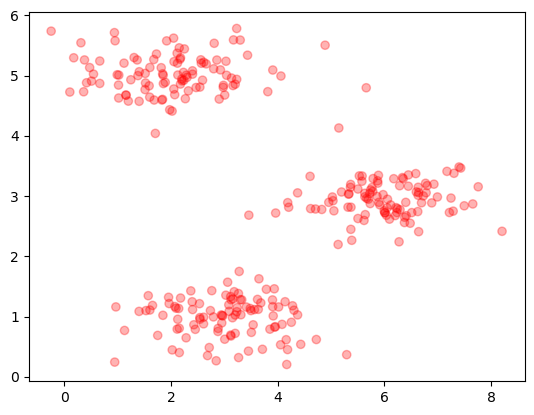

In [109]:
X = np.load("data/ex7_X.npy")

def plot_data_points(X, idx, ax):
    cmap = ListedColormap(["red", "green", "blue"])
    c = cmap(idx)
    ax.scatter(X[:, 0], X[:, 1], c=c, alpha=0.3)

print(f"Shape of X = {X.shape}")
idx = np.zeros(X.shape[0])
fig, ax = plt.subplots()
plot_data_points(X, idx, ax)


#### K-Means Algorithm

In [110]:
def k_means(X, K, initial_centroids, num_iters):
    """
    Runs the K-means algorithm on data matrix X.
    
    Args:
        X (ndarray): (m, n) Data matrix
        K (int): number of centroids
        num_iters (int): number of iterations
    
    Returns:
        centroids (ndarray): (K, n) Final centroids
        idx (ndarray): (m, ) Centroid assignments
    """
    m, n = X.shape
    # random_indices = np.random.choice(m, K, replace=False)
    # centroids = X[random_indices]
    centroids = initial_centroids
    idx = np.zeros(m)
    for i in range(num_iters):
        print(f"K-Means iteration {i}/{num_iters}")
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, K)
    
    return centroids, idx

In [111]:
def get_initial_centroids(X, K):
    """
    Returns K random centroids from the data points in X
    
    Args:
        X (ndarray): (m, n) Data matrix
        K (int): number of centroids
    
    Returns:
        centroids (ndarray): (K, n) Randomly chosen centroids
    """
    # Randomly reorder the indices of examples
    random_idx = np.random.permutation(X.shape[0])

    # Take the first K examples as centroids
    centroids = X[random_idx[:K]]

    return centroids

### Test the K-Means implementation on our data-set!

K-Means iteration 0/10
K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration 9/10


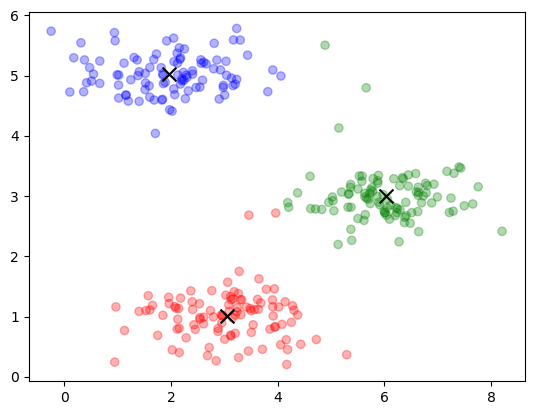

In [112]:


# Change the number of clusters to see how the data points are divided
num_clusters = 3
initial_centroids = get_initial_centroids(X, num_clusters)

centroids, idx = k_means(X, K=num_clusters, initial_centroids=initial_centroids, num_iters=10)
fig, ax = plt.subplots()
plot_data_points(X, idx, ax)
ax.scatter(centroids[:, 0], centroids[:, 1], c="black", marker="x", s=100)

<a name="4"></a>
## 4 - Image compression with K-means

In this exercise, you will apply K-means to image compression. 

* In a straightforward 24-bit color representation of an image$^{2}$, each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often refered to as the RGB encoding.
* Our image contains thousands of colors, and in this part of the exercise, you will reduce the number of
colors to 16 colors.
* By making this reduction, it is possible to represent (compress) the photo in an efficient way. 
* Specifically, you only need to store the RGB values of the 16 selected colors, and for each pixel in the image you now need to only store the index of the color at that location (where only 4 bits are necessary to represent 16 possibilities).

In this part, you will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image.
* Concretely, you will treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3- dimensional RGB space.
* Once you have computed the cluster centroids on the image, you will then use the 16 colors to replace the pixels in the original image.

### 4.1 Dataset

**Load image**

First, you will use `matplotlib` to read in the original image, as shown below.

In [113]:
# Load image of the bird
original_img = plt.imread("bird_small.png")

#### Visualize image

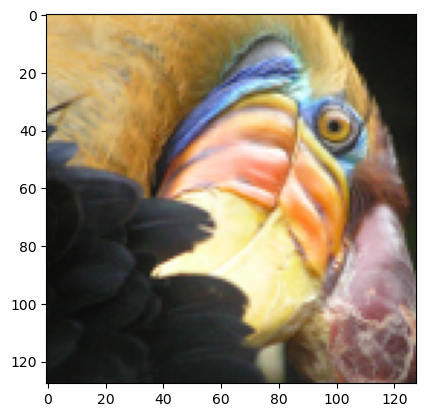

In [114]:
plt.imshow(original_img)

In [115]:
# Shape of original image
print(f"Shape of original image = {original_img.shape}")

Shape of original image = (128, 128, 3)


In [116]:
print(f"RGB value of first pixel of original image = {original_img[0, 0,]}")

RGB value of first pixel of original image = [0.85882354 0.7058824  0.40392157]


In [117]:
# Reshape the image to a 2D array of no. of pixels and 3 color values (RGB)
image_pixels_row = original_img.shape[0]
image_pixels_col = original_img.shape[1]
total_pixels = image_pixels_row * image_pixels_col
reshaped_img = np.reshape(original_img, (total_pixels, 3))

print(f"Shape of reshaped image = {reshaped_img.shape}")
print(f"RGB value of first pixel of reshaped image = {reshaped_img[0]}")


Shape of reshaped image = (16384, 3)
RGB value of first pixel of reshaped image = [0.85882354 0.7058824  0.40392157]


In [129]:
def run_kMeans(X, initial_centroids, max_iters=10, plot_progress=False):
    """
    Runs the K-Means algorithm on data matrix X, where each row of X
    is a single example
    """
    
    # Initialize values
    m, n = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids    
    idx = np.zeros(m)
    plt.figure(figsize=(8, 6))

    # Run K-Means
    for i in range(max_iters):
        
        #Output progress
        print("K-Means iteration %d/%d" % (i, max_iters-1))
        
        # For each example in X, assign it to the closest centroid
        idx = find_closest_centroids(X, centroids)
        
        # Optionally plot progress
        if plot_progress:
            plot_progress_kMeans(X, centroids, previous_centroids, idx, K, i)
            previous_centroids = centroids
            
        # Given the memberships, compute new centroids
        centroids = compute_centroids(X, idx, K)
    plt.show() 
    return centroids, idx


### K-Means on image pixels
Now, run the cell below to run K-Means on the pre-processed image.

In [154]:
K = 16
num_iters = 10

initial_centroids = get_initial_centroids(reshaped_img, K)
centroids, idx = k_means(reshaped_img, K, initial_centroids, num_iters=num_iters)
#centroids, idx = run_kMeans(reshaped_img, initial_centroids, num_iters)

K-Means iteration 0/10
K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration 9/10


In [155]:
print(f"Shape of idx = {idx.shape}")
print("Closest centroid for the first five elements:", idx[:5])

Shape of idx = (16384,)
Closest centroid for the first five elements: [12 12 12 12 12]


AttributeError: 'Axes3D' object has no attribute 'w_yaxis'

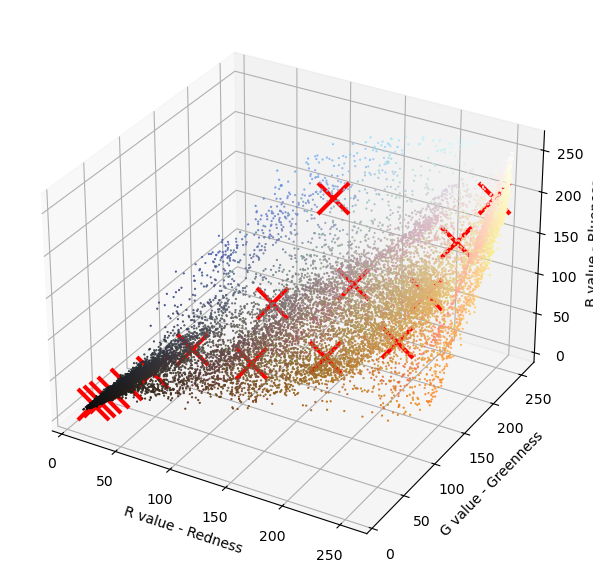

In [156]:
plot_kMeans_RGB(reshaped_img, centroids, idx, K)

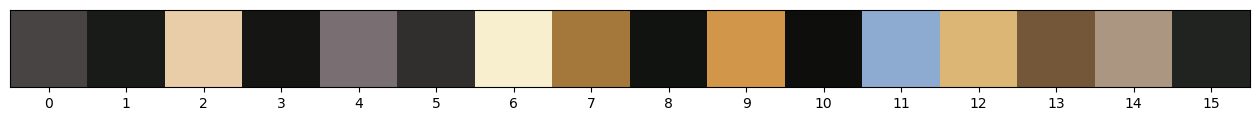

In [157]:
# Visualize the K colors selected
show_centroid_colors(centroids)

### Compress image

After finding the top $K=16$ colors to represent the image, you can now
assign each pixel position to its closest centroid using the
`find_closest_centroids` function. 
* This allows you to represent the original image using the centroid assignments of each pixel. 
* Notice that you have significantly reduced the number of bits that are required to describe the image. 
    * The original image required 24 bits (i.e. 8 bits x 3 channels in RGB encoding) for each one of the $128\times128$ pixel locations, resulting in total size of $128 \times 128 \times 24 = 393,216$ bits. 
    * The new representation requires some overhead storage in form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. 
    * The final number of bits used is therefore $16 \times 24 + 128 \times 128 \times 4 = 65,920$ bits, which corresponds to compressing the original image by about a factor of 6.

In [158]:

# Replace each pixel with the color of the closest centroid
X_recovered = centroids[idx, :] 

# Reshape image into proper dimensions
X_recovered = np.reshape(X_recovered, original_img.shape) 

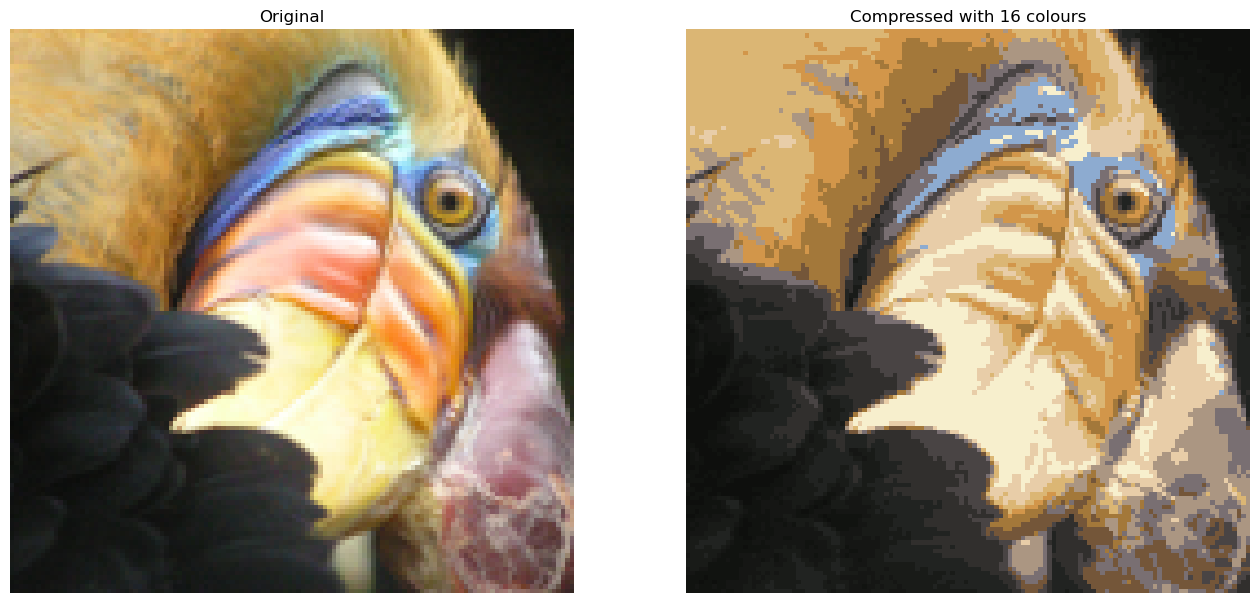

In [159]:
# Display original image
fig, ax = plt.subplots(1,2, figsize=(16,16))
plt.axis('off')

ax[0].imshow(original_img)
ax[0].set_title('Original')
ax[0].set_axis_off()


# Display compressed image
ax[1].imshow(X_recovered)
ax[1].set_title('Compressed with %d colours'%K)
ax[1].set_axis_off()